In [2]:
# 科学计算模块
import numpy as np
import pandas as pd

# 画图模块
import matplotlib.pyplot as plt

# 机器学习模块
from ML_basic_function import *

# Scikit-Learn
# 评估模器模块
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import  LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import  GridSearchCV

# 实用函数
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 数据准备
from sklearn.datasets import load_iris


# 集成算法的参数空间与网格优化

如随机森林中所展示的，集成算法的超参数种类繁多、取值丰富，且参数之间会相互影响、共同作用于算法的最终结果，因此集成算法的调参是一个难度很高的过程。在超参数优化还未盛行的时候，随机森林的调参是基于方差-偏差理论(variance-biastrade-off)和学习曲线完成的，而现在我们可以依赖于网格搜素来完成自动优化。在对任意算法进行网格搜索时，我们需要明确两个基本事实：

1、参数对算法结果的影响力大小

2、用于进行搜索的参数空间

对随机森林来说，我们可以大致如下排列各个参数对算法的影响：

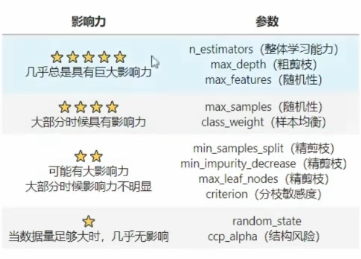

随机森林在剪枝方面的空间总是很大的，因为默认参数下树的结构基本没有被影响（也就是几乎没有剪枝），因此当随机森林过拟合的时候，我们可以尝试粗、精、随机等各种方式来影响随机森林。通常在网格搜素当中，我们会考虑所有有巨大影响力的参数、以及1、2个影响力不明显的参数。

虽然随机森林调参的空间较大，大部分人在调参过程中依然难以突破，因为**树的集成模型的参数空间非常难以确定**。当没有数据支撑时，人们很难通过感觉或经验来找到正确的参数范举例来说，我们也很难直接判断究竟多少棵树对于当前的模型最有效，同时，我们也很难判断不剪枝时一棵决策树究竟有多深、有多少叶子、或者一片叶子上究竟有多少个样本，更不要谈凭经验判断树模型整体的不纯度情况了。可以说，当森林建好之后，我们简直是对森林一无所知。对于网格搜索来说，新增一个潜在的参数可选值，计算量就会指数级增长，因此找到有效的参数空间非常重要。此时我们就要引入两个工具来帮助我们：

1、学习曲线

2、决策树对象Tree的属性

* 学习曲线

学习曲线是以参数的不同取值为横坐标，模型的结果为纵坐标的曲线。当模型的参数较少、且参数之间的相互作用较小时，我们可以直接使用学习曲线进行调参。但对于集成算法来说，学习曲线更多是我们探索参数与模型关系的关键手段。许多参数对模型的影响是确定且单调的，例如 n_estimators树越多模型的学习能力越强，再比如ccp_alpha，该参数值越大模型抗过拟合能力越强，因此我们可能通过学习曲线找到这些参数对模型影响的极限。我们会围绕这些极限点来构筑我们的参数空间。

先来看看n_estimators的学习曲线：

In [4]:
from sklearn.ensemble import  RandomForestRegressor as RFR
from sklearn.model_selection import  cross_validate, KFold

In [1]:
# 参数取值，由于现在我们只调整了一个参数，因此参数的范围可以取得大一些，取值也可以更密集

Option = [1, * range(5, 101, 5)]

In [ ]:
# 生成保存模型结果的arrays
trainRMSE = np.array([])
testRMSE = np.array([])
trainSTD = np.array([])
testSTD = np.array([])

# 在参数取值中循环
for n_estimators in Option:
    # 按照当前参数实例化模型
    reg_f = RFR(n_estimators=n_estimators, random_state=1412)

    # 实例化交叉验证方式，输出交叉验证结果
    cv = KFold(n_splits=5, shuffle=True, random_state=1412)
    result_f = cross_validate(reg_f, X, y, cv=cv, scoring='neg_mean_squared_error', return_train_score=True)

    # 根据输出的MSE进行RMSE计算
    train = abs(result_f['train_score']) ** 0.5
    test = abs(result_f['test_score']) ** 0.5

    # 将本次交叉验证中RMSE的均值和标准差记录下来
    trainRMSE = np.append(trainRMSE, train.mean())  # 效果越好
    testRMSE = np.append(testRMSE, test.mean())
    trainSTD = np.append(trainSTD, train.std()) # 效果越稳定
    testSTD = np.append(testSTD, test.std())


In [ ]:
def plotCVresult (Option, trainRMSE, testRMSE, trainSTD, testSTD):
    plt.figure(figsize=(10, 6))
    plt.plot(Option, trainRMSE, label='train', marker='o')
    plt.fill_between(Option, trainRMSE - trainSTD, trainRMSE + trainSTD, alpha=0.3)
    plt.plot(Option, testRMSE, label='test', marker='o')
    plt.fill_between(Option, testRMSE - testSTD, testRMSE + testSTD, alpha=0.3)
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('RMSE')
    plt.show()

![alt text](image-149.png)

当绘制学习曲线时，我们可以很容易找到泛化误差开始上升、或转变为平稳趋势的转折点。因此我们可以选择转折点或转折点附近的n_estimators取值，例如20。然而，n_estimators会受到其他参数的影响，例如：

* 单棵决策树的结构更简单时（依赖剪枝时），可能需要更多的树
* 单棵决策树训练的数据更简单时（依赖随机性时），可能需要更多的树

因此n_estimators的参数空间可以被确定为range(20,100,5)，如果你比较保守，甚至可以确认为是range(15,25,5)。

* 决策树对象Tree

在sklearn中，树模型是单独的一类对象，每个树模型背后都有一套完整的属性供我们调用，包括树的结构、树的规模等众多细节。在之前的课程中，我们曾经使用过树模型的绘图功能plot_tree，除此之外树还有许多有用的属性。随机森林是树组成的算法，因此也可以调用这些属性。我们来举例说明：

![alt text](image-150.png)

根据经验，当决策树不减枝且在训练集上的预测结果不错时，一棵树上的叶子量常常与样本量相当或比样本量更多，算法结果越槽糕，叶子量越少，如果RMSE很高或者R2很低，则可以考虑使用样本量的一半或3/4作为不减枝时的叶子量的参考。

* 使用网格搜索在随机森林上进行调参

现在模型正处于过拟合的状态，需要抗过拟合，且整体数据量不是非常多，随机抽样的比例不宜减小，因此我们挑选以下五个参数进行搜索：n_estimators,max_depth,max_features,min_impurity_decrease,criterion 


![alt text](image-151.png)

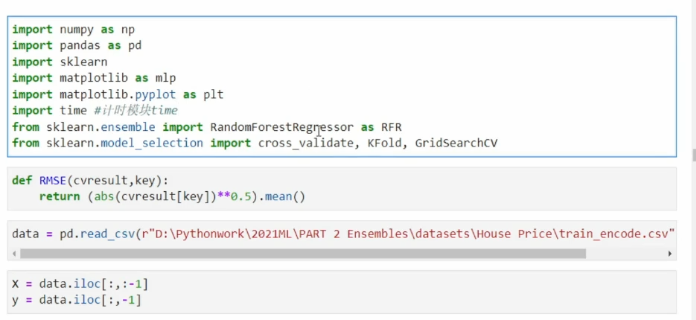

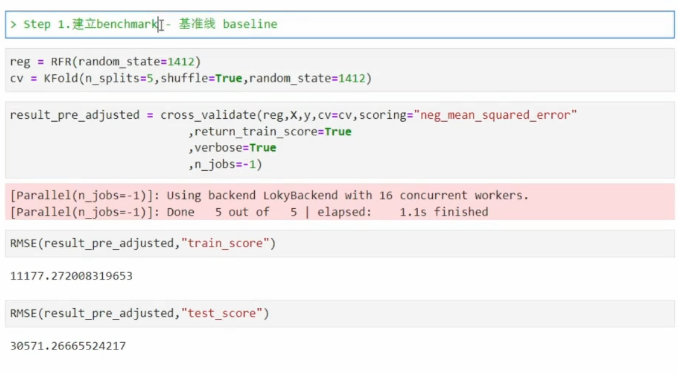

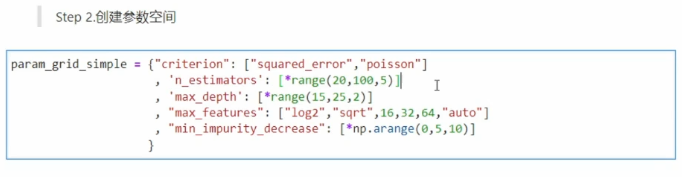

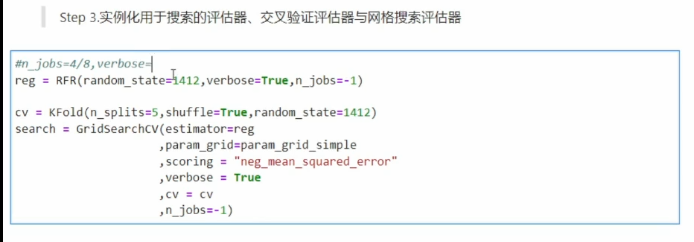

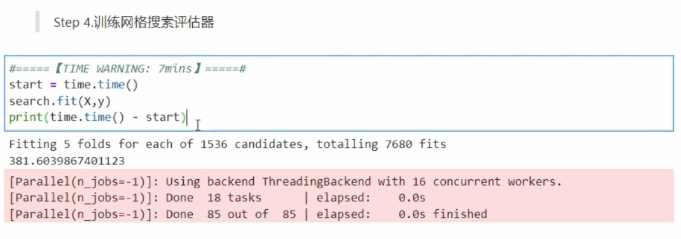

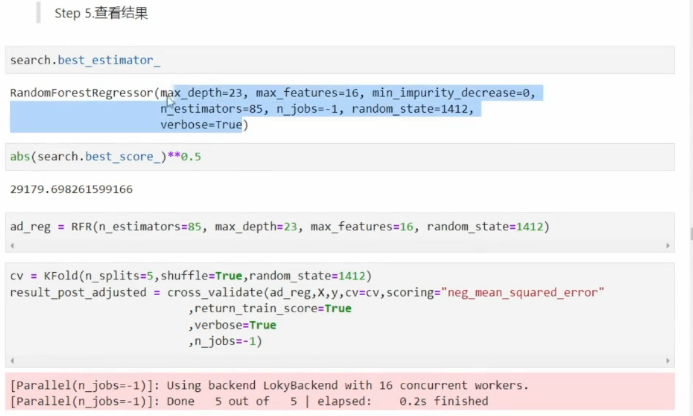